# Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, normalized_mutual_info_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from helpers.project import feature_key
from helpers.project import wrap_text

%matplotlib inline
pd.set_option('display.max_columns', 300)
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "STIXGeneral"

# Notes on data wrangling
### Filtering
The [ANES (American National Election Studies) Time Series Cumulative Data File](http://www.electionstudies.org/studypages/anes_timeseries_cdf/anes_timeseries_cdf.htm) contains survey data of eligible voters from 1948 to 2012, resulting in a dataset consisting of 55,674 respondents and 953 features stored as a CSV ([anes_cdf_raw.csv](https://github.com/zhao1701/Polling-Error-Correction/blob/master/Data/anes_cdf_raw.csv)). Because we are only interested in respondents from presidential election years on or after 2000 and because loading the full dataset can be somewhat slow on a local machine, it is first necessary to filter out all unnecessary data.

The file [01 Data Filtering.py](https://github.com/zhao1701/Polling-Error-Correction/blob/master/01%20Data%20Filtering.py) generates a smaller intermediate CSV ([anes_cdf_abridged](https://github.com/zhao1701/Springboard-Capstone-I/blob/master/Data/anes_cdf_abridged.csv) containing only data relevant to this project. First, respondents meeting the following criteria are **excluded** from the project:

- Respondents interviewed prior to 2000 (42,908 respondents)
- Respondents interviewed during a midterm election year (1,511 of remaining respondents)
- Respondents for which no post-election interview data is present (1,022 of remaining respondents)
- Respondents for which no voting data is present (23 of remaining respondents)
- Respondents with abbreviated pre-election interviews (836 of remaining respondents)

As a result, the intermediate dataset generated will include 9,374 respondents. Given the number of remaining respondents, features with less than 6,000 instances of non-null values are also excluded due to substantial amounts of missing data. An additional subset of features were excluded for redudancy with other features (ex: age vs. age group) as well as general irrelevance to the predictive task at hand (ex: Interviewee ID Number). Full documentation is available as comments within the [file itself](https://github.com/zhao1701/Polling-Error-Correction/blob/master/01%20Data%20Filtering.py). In the end, the new dataset consists of 9374 respondents and 263 features.

### Cleaning
The remaining 263 features need to be cleaned/converted so as to be suitable for various analysis and machine learning algorithms later on. They largely fall within 5 main categories:
1. **Continuous**: Features that measure a number or amount (ex. age or number of children). There are relatively few of these and very little cleaning, if any, needs to be done.
- **Quasi-continuous**: Like continuous features, these features are meant to measure an amount, but in practice the feature is not truly continuous. For example, the surveys contain a large number of "Thermometer" questions that measure the respondent's sentiment towards an individual, group, or institution, with 0 indicating the most negative sentiment and 100 indicating the most positive. However, many respondents prefer to provide answers in multiples of 5, 10, and 25, resulting in irregular spikes and gaps uncharacteristic of a truly continuous variable. To address this, some smoothing is applied by applying integer division by 10 to all values. Though some gaps still remain, for all intents and purposes, the feature is treated as continuous.
- **Binary**: Features for which there exist only 2 possible values. These are all originally encoded as strings, so they need to be converted into boolean or integer data types.
- **Categorical**: Features for which there exist a limited number of possible values, and these values have no intrinsic ordered relationship with one another (ex: ethnicity of respondent). These features are converted into a set of binary features using [one-hot encoding](https://en.wikipedia.org/wiki/One-hot).
- **Ordinal**: Features for which there exist a limited number of possible values, and these values have intrinsic ordered relationship with one another (ex: features using the [Likert scale](https://en.wikipedia.org/wiki/Likert_scale). These features are converted from strings into an integer representation.

The file [02 Data Cleaning.py](https://github.com/zhao1701/Polling-Error-Correction/blob/master/02%20Data%20Cleaning.py) generates a CSV of converted data ([anes_cdf_converted.csv](https://github.com/zhao1701/Springboard-Capstone-I/blob/master/Data/anes_cdf_converted.csv)) and addresses additional issues:
- **Explicit missing values**: Some missing values in the dataset are represented as null values, while others are represented explictly, most typically with a string beginning with 'NA' or a string code '999'. These are converted to null values for consistency 
- **Sparse categories**: Some categorical features include response categories that apply to very few respondents. In these situations, the sparse category is either combined with a larger category or converted into null values, decided on a case by case basis.
- **"Don't know" responses**: Some ordinal features include response categories that do not fit within an otherwise sensible ordering scheme. For example, a feature may correspond to the survey question, "How liberal or conservative are you?" with valid responses of "Very liberal", "Moderately liberal", "Moderate", "Moderately conservative", "Very conservative" and "Don't know". In this situation, a new binary feature is created for the explicit purpose of recording whether a respondent answered "Don't know", and the "Don't know" responses of the ordinal feature are converted to null values.

### Response Key
As there are a high number of features, many with detailed categorical responses reduced to a number, a [response key](https://github.com/zhao1701/Polling-Error-Correction/blob/master/02%20Data%20Cleaning%20-%20Response%20Key.xlsx) is maintained to keep track of the meanings of each feature as well as that of each feature's values.

# Basic Info

In [4]:
df_orig = pd.read_csv('../data/anes_cdf_converted.csv')
df_orig.head()

Unnamed: 0  year   age congressional_district state  gender  weight  \
0           0  2000  49.0                   MN01    MN       0  1.2886   
1           1  2000  35.0                   MI01    MI       1  0.8959   
2           2  2000  57.0                   IL11    IL       1  1.0454   
3           3  2000  63.0                   ME02    ME       0  0.6005   
4           4  2000  40.0                   MA01    MA       1  1.9270   

   final_vote  VCF0108  VCF0113  VCF0127  VCF0143  VCF0146  VCF0311  VCF0346  \
0           2      0.0        0        0      1.0      1.0      1.0      1.0   
1           0      0.0        0        0      1.0      1.0      0.0      1.0   
2           1      0.0        0        0      1.0      1.0      1.0      0.0   
3           1      0.0        0        1      0.0      1.0      1.0      0.0   
4           2      0.0        0        0      1.0      1.0      1.0      1.0   

   VCF0347  VCF0348  VCF0349  VCF0358  VCF0359  VCF0360  VCF0361  VCF0370  \
0      1.0      0.0      0.0      0.0      1.0      0.0      1.0      1.0   
1      0.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2      0.0      1.0      1.0      0.0      0.0      1.0      1.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      1.0      1.0      0.0      1.0      1.0      1.0      0.0   

   VCF0371  VCF0372  VCF0373  VCF0374  VCF0380  VCF0386  VCF0392  VCF0475  \
0      0.0      1.0      1.0      1.0      1.0      1.0      0.0      1.0   
1      0.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2      1.0      1.0      0.0      1.0      0.0      1.0      0.0      1.0   
3      0.0      1.0      0.0      0.0      1.0      1.0      1.0      0.0   
4      0.0      1.0      1.0      0.0      1.0      1.0      0.0      0.0   

   VCF0481  VCF0487  VCF0493  VCF0450  VCF0501  VCF0702  VCF0704a  VCF0707  \
0      1.0      1.0      0.0      0.0      1.0        1       0.0      0.0   
1      0.0      0.0      0.0      1.0      1.0        0       NaN      NaN   
2      1.0      0.0      1.0      1.0      0.0        1       1.0      NaN   
3      0.0      0.0      0.0      1.0      0.0        1       1.0      1.0   
4      1.0      1.0      0.0      1.0      1.0        1       0.0      1.0   

   VCF0708  VCF0717  VCF0718  VCF0719  VCF0720  VCF0721  VCF0724  VCF0729  \
0      0.0      1.0      0.0      0.0      0.0      0.0      1.0      1.0   
1      NaN      0.0      0.0      0.0      0.0      1.0      1.0      0.0   
2      NaN      1.0      0.0      0.0      0.0      0.0      1.0      1.0   
3      1.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      1.0      0.0      0.0      0.0      0.0      0.0      1.0      1.0   

   VCF0731  VCF0740  VCF0741  VCF0742  VCF0846  VCF0878  VCF0905  VCF9021  \
0      1.0      0.0      0.0      0.0      1.0      0.0      1.0      1.0   
1      1.0      0.0      0.0      1.0      0.0      1.0      1.0      1.0   
2      1.0      0.0      0.0      0.0      1.0      1.0      1.0      0.0   
3      1.0      0.0      0.0      0.0      1.0      0.0      1.0      0.0   
4      1.0      0.0      0.0      0.0      0.0      0.0      1.0      0.0   

   VCF9029  VCF9030a  VCF9030b  VCF9030c  VCF9031  VCF0204_dk  VCF0204  \
0      NaN       1.0       0.0       1.0      0.0       False      8.0   
1      NaN       0.0       0.0       0.0      0.0       False     10.0   
2      NaN       0.0       0.0       0.0      0.0       False      8.0   
3      NaN       1.0       1.0       1.0      0.0       False      5.0   
4      NaN       1.0       1.0       0.0      0.0       False      8.0   

   VCF0206_dk  VCF0206  VCF0207_dk  VCF0207  VCF0209_dk  VCF0209  VCF0210_dk  \
0       False      8.0       False      8.0       False      7.0       False   
1       False     10.0       False     10.0       False     10.0       False   
2       False      8.0       False      8.0       False      6.0       

Note the inclusion of a **weight** feature in the dataset. Because the ANES surveys use [stratified sampling](http://stattrek.com/statistics/dictionary.aspx?definition=Stratified%20sampling) as opposed to simple random sampling, sampling weights are provided for the purpose of making inferences about the population. However, the prediction problem at hand simply involves classifying voter and non-voters rather than inferring some population parameter, so sampling weights are ignored in this analysis.

As we intend to use data from 2000, 2004, and 2008 to classify voters and non-voters in 2012, it is necessary to exclude all 2012 respondents from this data exploration so that the project might somewhat approximate a real-world situation. Before we do that, though, we take a peek at how much data comes from each year.

2000     718
2004    1066
2008    2102
2012    5488
Name: year, dtype: int64


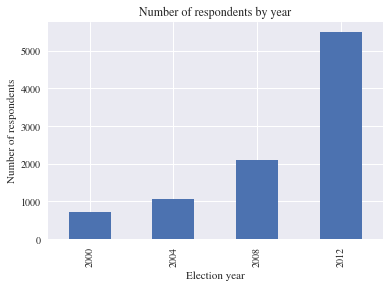

In [5]:
print(df_orig.year.value_counts().sort_index())
g = df_orig.year.value_counts().sort_index().plot(kind = 'bar')
g.set_title('Number of respondents by year')
g.set_ylabel('Number of respondents')
g.set_xlabel('Election year')

There is an unfortunate abundance of 2012 data that must be held out for the test set, leaving the training set with a little under 4000 respondents. Though not ideal, this should still be a sufficient number of training examples to build a classification model.

In [23]:
df = df_orig[df_orig.year < 2012]
len(df)

3886

We also drop a number of features that would have caused [data leakage](https://www.kaggle.com/wiki/Leakage), where features in the training data inadvertently give away the target value, resulting in unrealistic model performance.

In [24]:
columns_to_drop = ['VCF0734','VCF0736','VCF1011','VCF0704','VCF0710','VCF0709','VCF0703','VCF0707','VCF0708','VCF1011']
for column in columns_to_drop:
    df = df.iloc[:, ~df.columns.str.contains(column)]

# Assessing generalizability

Because 2012 data is being excluded for testing and model assessment later, concern about the generalizability of a classification model trained off past elections' data is warranted. First, we examine the distribution of the target variable ("Did the respondent vote?") as well as whether this distribution remains consistent for different election years.

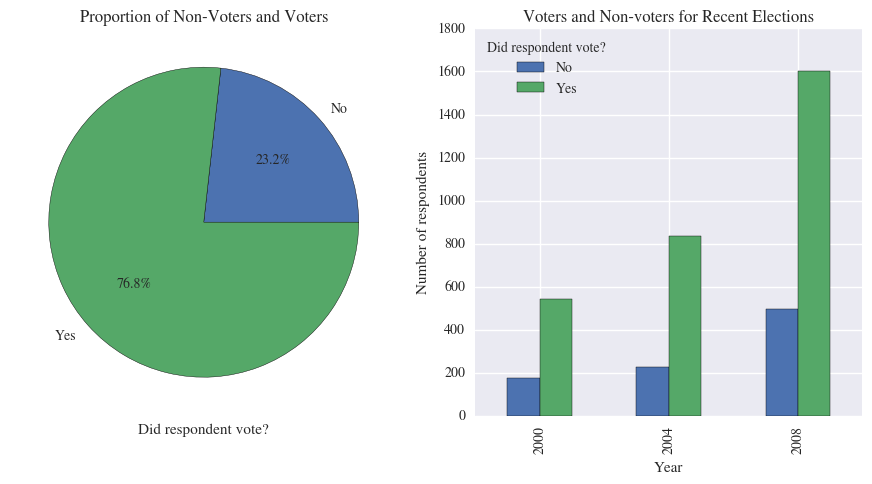

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5))

g = df.VCF0702.value_counts().sort_index().plot(kind = 'pie', ax = axes[0], labels = ['No','Yes'], autopct='%1.1f%%')
g.set(title = 'Proportion of Non-Voters and Voters', xlabel = 'Did respondent vote?', ylabel = ' ')
plt.legend(labels = ['No','Yes'])

df_temp = df.groupby([df.year, df.VCF0702]).size()
df_temp = df_temp.unstack('VCF0702')
g = df_temp.plot(kind = 'bar', ax = axes[1])
g.set(xlabel = 'Year', ylabel = 'Number of respondents', title = 'Voters and Non-voters for Recent Elections')
g.legend(['No','Yes'], loc = 0, title = 'Did respondent vote?')

The good news is that it appears voter turnout is consistent across election years. The less-good news is that the dataset is fairly unbalanced, so metrics like classification accuracy become less meaningful while [F1 scores](https://en.wikipedia.org/wiki/F1_score) and [ROC curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) take on greater importance. The actual proportion of voters who claim to have voted is suspiciously high. The ANES surveys poll from a sample universe of [**eligible voters**](http://www.electproject.org/home/voter-turnout/faq/denominator) rather than **registered voters**, so one expects the survey's data on turnout rate to mirror [widely-accepted turnout statistics](http://www.fairvote.org/voter_turnout#voter_turnout_101) that show turnout rates between 50% and 60% of the voting eligible population. Instead the ANES surveys have turnout closer to 80%.

Let's check that this is not a result of disregarding sampling weights.

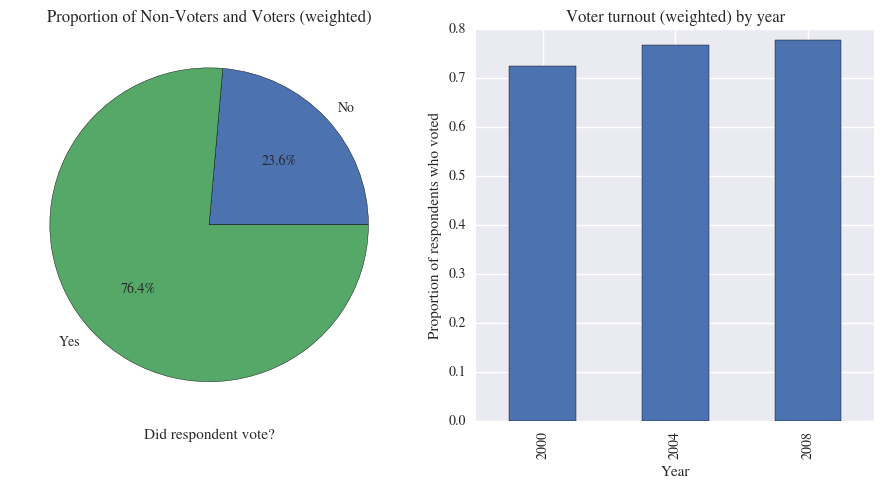

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (9, 5))

df.groupby('VCF0702').sum().weight.plot(kind = 'pie', ax = axes[0], labels = ['No','Yes'], autopct='%1.1f%%')
axes[0].set(title = 'Proportion of Non-Voters and Voters (weighted)', xlabel = 'Did respondent vote?', ylabel = '')

table = df.groupby(['VCF0702','year']).sum().weight.unstack('year')
total = table.loc[0,:] + table.loc[1,:]
votes = table.loc[1,:]
(votes / total).plot(kind = 'bar', ax = axes[1])
axes[1].set(title = 'Voter turnout (weighted) by year', xlabel = 'Year',
            ylabel = 'Proportion of respondents who voted')

plt.tight_layout()

With proportions essentially unchanged, this appears to be a fairly cut and dry case of [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias) where respondents who did not actually vote claimed to have voted out of a desire to report good behavior. If the survey's ground truth about voting propensity is unreliable, this may prove problematic when assessing the performance of classification models. However, whether this will be the case cannot be known at this moment.

We can also assess generalizility by investigating whether there exists significant differences among the data for each election year. A traditional statistical approach would involve performing z- and t-tests for differences between proportions and means on each feature. However, a more novel and efficient approach involves [adversarial validation](http://fastml.com/adversarial-validation-part-one/) where we check whether a classification algorithm can discern the year the respondent was interviewed. If it can, this suggests the data for each election year may contain significant differences and classification models on other target features may struggle to generalize.

In [56]:
columns_to_drop = ['year','Unnamed: 0','congressional_district','state']
X = df.drop(columns_to_drop, axis = 1)

columns_to_drop = ['VCF9048','VCF0804','VCF0823','VCF0138','VCF9085','VCF0734','VCF0803','VCF0879','VCF9021',
                  'VCF9047','VCF9093','VCF9009','VCF0429','VCF9084','VCF0879','VCF0233','VCF9086','VCF0219',
                  'VCF9030','VCF9017','VCF9016','VCF9092','VCF9087','VCF9048','VCF9029','VCF0502','VCF0541',
                  'VCF0542','VCF9089','VCF0909','VCF0904','VCF0905','VCF0907','VCF0906','VCF9056']
for column in columns_to_drop:
    X = X.iloc[:, ~X.columns.str.contains(column)]

imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent')
X_train = imp.fit_transform(X)

for year in [2000, 2004, 2008]:
    y = df.year == year
    cv_score = cross_val_score(LogisticRegression(), X_train, y, scoring = 'roc_auc', cv = 3)
    print('ROC area,', str(year) + ':', cv_score.mean())

ROC area, 2000: 0.962699779745
ROC area, 2004: 0.922743219998
ROC area, 2008: 0.977443849439


Indeed, we see that even after removing features with incomplete data that might inadvertently give away the year, a basic logistic regression can still easily distinguish between each election cycle. This in of itself does not mean a classification model is guaranteed to fail to generalize (features that serve as excellent predictors of election year may be poor predictors of voting propensity), but it does provide a warning that however well a model performs on training data, its performance is likely to be lower, possibly much lower, on test data.

# Searching for hidden structure
Next we apply two techniques to explore whether any intrinsic structure to the data can be uncovered. Both involving compressing high-dimensional data into lower dimensions so that the data may be visualized.
### Principal Component Analysis (PCA)
[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) provides a convenient means of projecting a high-dimensional feature space onto a lower-dimensional subspace. The orthogonal basis of this subspace are the principal components. For our purposes, we will project the data onto a 3-dimensional subspace to see if any meaningful patterns can be uncovered.

<IPython.core.display.Javascript object>


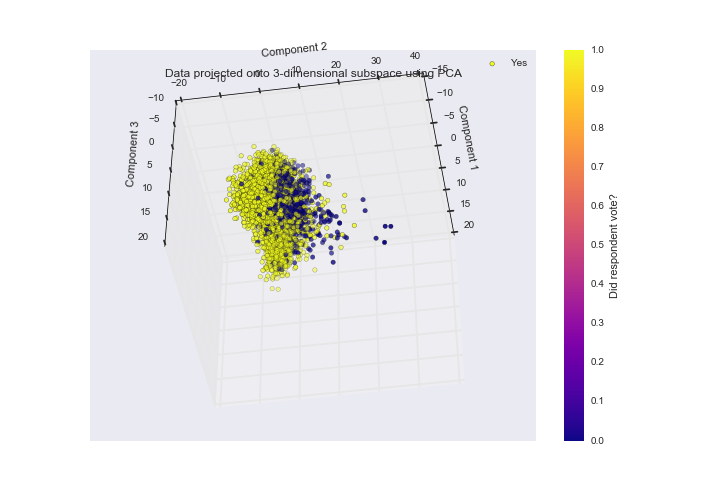

Proportion of total variance explained by 3 principal components 0.139560276228


In [13]:
X_pca = df.drop(['Unnamed: 0','state','congressional_district','VCF0702'], axis = 1)
y_pca = df.VCF0702

X_pca = imp.fit_transform(X_pca)
X_pca = StandardScaler().fit_transform(X_pca)

pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_pca)

%matplotlib notebook
ax = plt.figure(figsize = (10,7)).add_subplot(111, projection = '3d')
g = ax.scatter(X_pca[:,0], X_pca[:,1],X_pca[:,2], c = y_pca, cmap = 'plasma')
ax.set(title = 'Data projected onto 3-dimensional subspace using PCA', xlabel = 'Component 1', ylabel = 'Component 2',
      zlabel = 'Component 3')
ax.legend(['Yes','No'])
cbar = plt.colorbar(g, ax = ax)
cbar.set_label('Did respondent vote?')

print('Proportion of total variance explained by {} principal components'.format(pca.n_components_),
      pca.explained_variance_ratio_.sum())

The 3-dimensional plot above does not reveal any obvious separation between voters and non-voters, but there appear to be regions where voters are much more abundant as well as regions where voters and non-voters overlap, but with a greater concentration of non-voters. It is important to note that projecting the entire feature space onto a 3-dimensional subspace only preserves 14.0% of the total variance of the data, so it is possible that better separation exists in higher dimensions where more variance is preserved.

### T-Distributed Stochastic Neighbor Embedding (t-SNE)
An obvious drawback of using PCA to visualize high-dimensional data is the information lost in projecting a large number of features onto two or three dimensions. [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) overcomes these limitations, but at the cost of being much more mathematically complex and thus computationally expensive. Roughly speaking, the procedure is a non-linear transformation that attempts to group similar data points together into clusters while preventing overly dissimilar  data points from being represented by an impractical distance in the resulting visualization.

In the interest of performance, the data is first compressed to 100 features using PCA, resulting in the preservation of 66.8% of total variation before applying the t-SNE algorithm.

Proportion of total variance explained by 100 principal components 0.668176949474


<IPython.core.display.Javascript object>


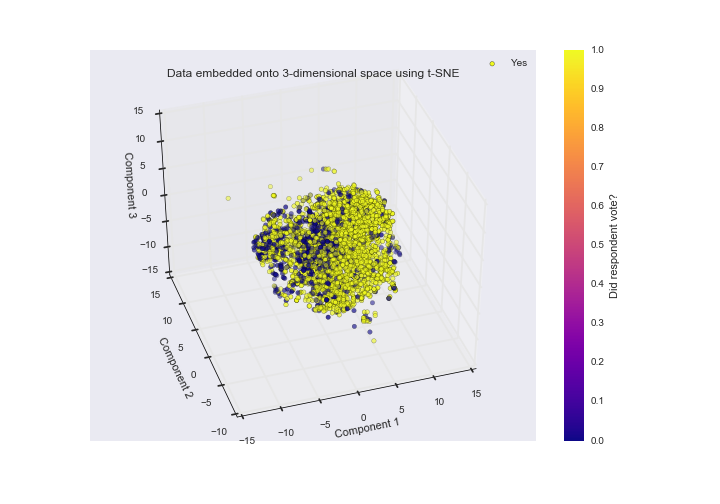

In [12]:
X_tsne = df.drop(['Unnamed: 0','state','congressional_district','VCF0702'], axis = 1)
y_tsne = df.VCF0702

X_tsne = imp.fit_transform(X_tsne)
X_tsne = StandardScaler().fit_transform(X_tsne)

pca = PCA(n_components = 100)
X_tsne = pca.fit_transform(X_tsne)

tsne = TSNE(n_components = 3, perplexity = 30, early_exaggeration = 4, learning_rate = 1000, n_iter = 1000)
X_tsne = tsne.fit_transform(X_tsne)

print('Proportion of total variance explained by {} principal components'.format(pca.n_components_),
      pca.explained_variance_ratio_.sum())

%matplotlib notebook
ax = plt.figure(figsize = (10,7)).add_subplot(111, projection = '3d')
g = ax.scatter(X_tsne[:,0], X_tsne[:,1],X_tsne[:,2], c = y_tsne, cmap = 'plasma')
ax.set(title = 'Data embedded onto 3-dimensional space using t-SNE', xlabel = 'Component 1', ylabel = 'Component 2',
      zlabel = 'Component 3')
cbar = plt.colorbar(g, ax = ax)
cbar.set_label('Did respondent vote?')

The t-SNE plot above tells a similar story to that of PCA; no obvious separation can be discerned, but the distribution of voters and non-voters in three-dimensional space isn't completely random and uniform either. As with PCA, different regions can have noticeably different compositions.

Next, we take a deeper dive into the data and see which features might relate closely to voting propensity.

# A quick survey of binary features
A straightforward way of uncovering which binary features might be most helpful in classifying voters from non-voters is simply to examine the difference in proportion of non-voters between the two possible categories of each binary feature and assessing the statistical significance with a [two-proportion z-test](http://stattrek.com/hypothesis-test/difference-in-proportions.aspx?Tutorial=AP).

In [68]:
def binary_vs_target(firstFeatureName, lastFeatureName, targetName, featureKey, df):
    firstIndex = df.columns.get_loc(firstFeatureName)
    lastIndex = df.columns.get_loc(lastFeatureName)
    targetIndex = df.columns.get_loc(targetName)
    
    num_plots = lastIndex - firstIndex + 1
    fig, axes = plt.subplots(num_plots // 4 + 1, 4, figsize = (10, .7 * num_plots))
    
    p_list = []

    for axesIndex, index in zip(range(0, num_plots), range(firstIndex, lastIndex + 1)):
        
        a = df.iloc[:,index]
        b = df.iloc[:,targetIndex]
        
        n1 = sum(a == 0)
        n2 = sum(a == 1)
        x1 = sum((a == 0) & (b == 0))
        x2 = sum((a == 1) & (b == 0))
        p1 = x1 / n1
        p2 = x2 / n2
        g = sns.barplot([0,1],[p1,p2], ax = axes[axesIndex // 4][axesIndex % 4])
        if axesIndex % 4 == 0:
            g.set_ylabel('Proportion NV\nper response')
        
        z = np.abs((p1 - p2) / np.sqrt(p1 * (1-p1) / n1 + p2 * (1-p2) / n2))
        p_value = 2 * (1 - norm.cdf(z))
        feature_name = wrap_text(featureKey[df.columns[index]])
        title = feature_name + '\n' + '('+ df.columns[index] + ')'
        g.set_title(title)
        g.set_xticklabels(['No','Yes'])
        
        correlation = abs(np.corrcoef(a.fillna(a.mean()),b.fillna(b.mean()))[0][1])
        mutual_info = normalized_mutual_info_score(df.iloc[:,index],df.iloc[:,targetIndex])
        
        p_list.append([df.columns[index], featureKey[df.columns[index]], abs(p1-p2), p_value, correlation,
                       mutual_info])
    fig.tight_layout()
    return p_list

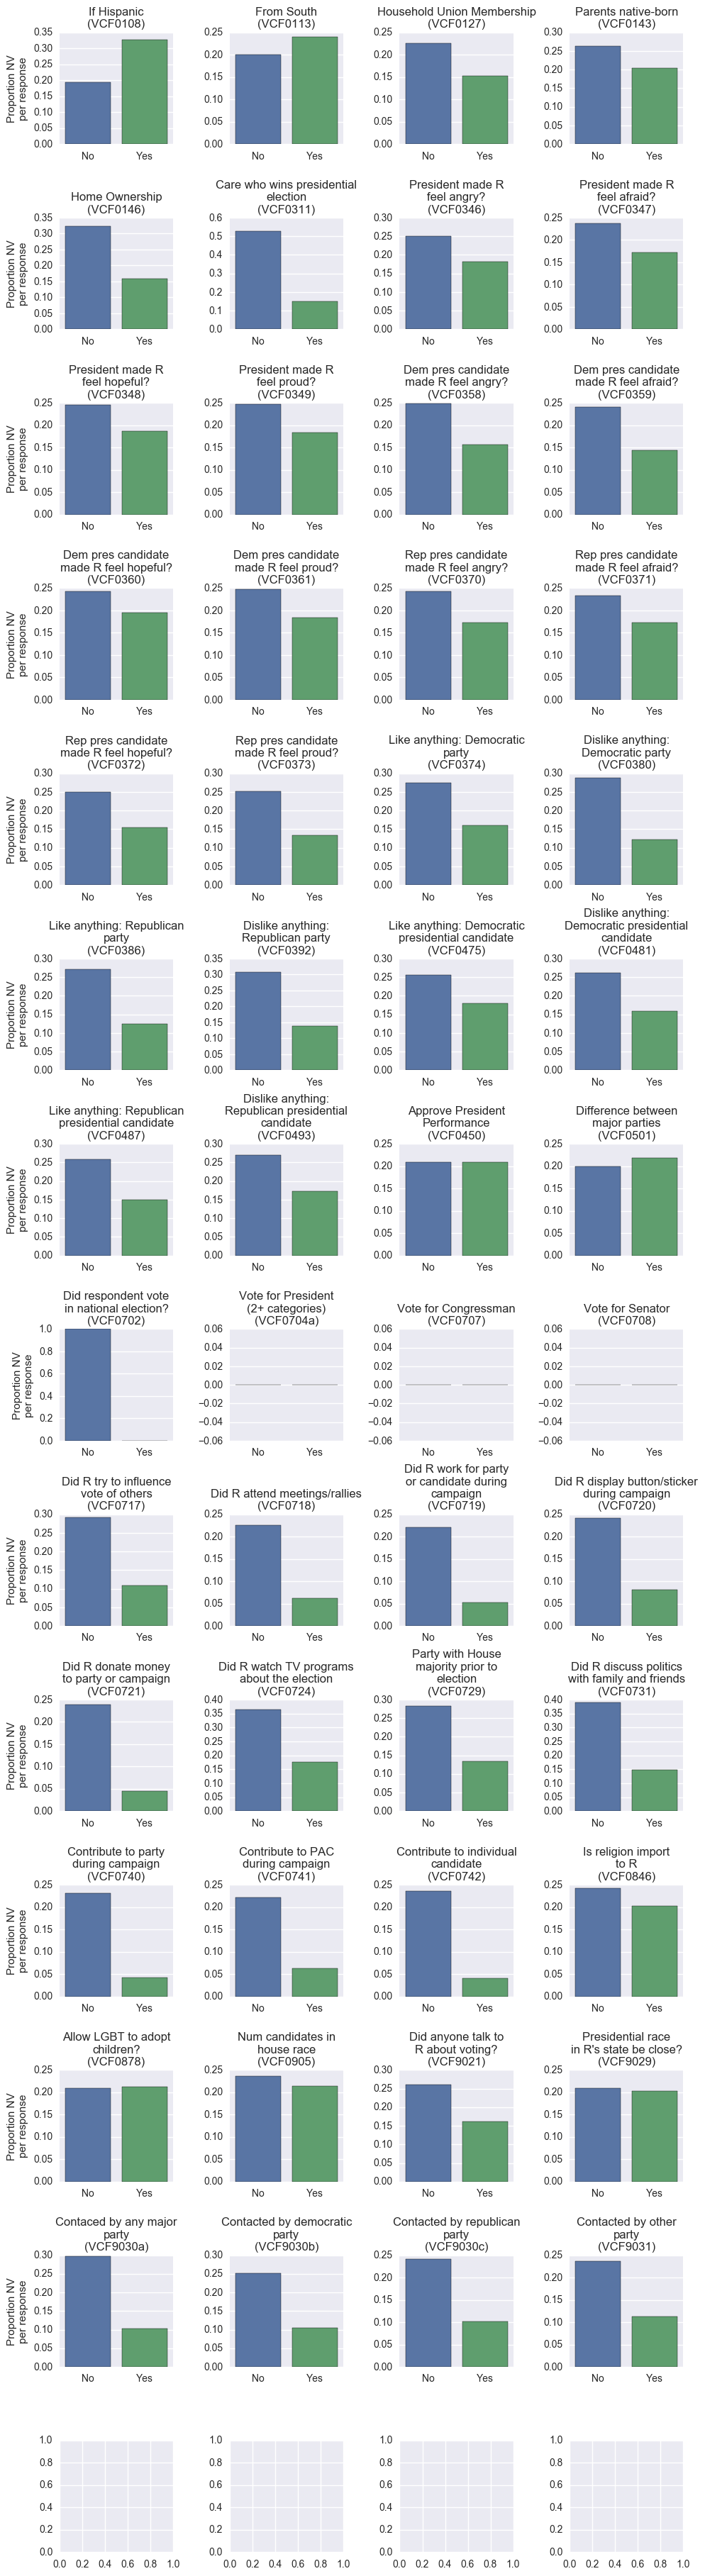

In [69]:
%matplotlib inline
p_list = binary_vs_target('VCF0108', 'VCF9031', 'VCF0702', feature_key, df)

To make sense of all the data above, we rank each binary feature by the absolute value of the difference between proportions of non-voters in each category. A difference of proportions is used instead of the p-value simply because so many p-values were zeros.

In [90]:
p_df = pd.DataFrame(p_list)
p_df.columns = ['feature','description','difference_proportions','p-value','correlation','mutual_info']
p_df = p_df.iloc[1:,:]
p_df.sort_values(by = 'difference_proportions', ascending = False).iloc[1:,:].head(10)

feature                                        description  \
5    VCF0311                Care who wins presidential election   
39   VCF0731     Did R discuss politics with family and friends   
42   VCF0742                 Contribute to individual candidate   
36   VCF0721            Did R donate money to party or campaign   
48  VCF9030a                        Contaced by any major party   
37   VCF0724         Did R watch TV programs about the election   
40   VCF0740                Contribute to party during campaign   
32   VCF0717              Did R try to influence vote of others   
21   VCF0392                 Dislike anything: Republican party   
34   VCF0719  Did R work for party or candidate during campaign   

    difference_proportions  p-value  correlation  mutual_info  
5                 0.379882      0.0     0.348378     0.107258  
39                0.242803      0.0     0.244435     0.098047  
42                0.195700      0.0     0.150652     0.035553  
36                0.194031      0.0     0.157809     0.036732  
48                0.193778      0.0     0.233234     0.050849  
37                0.190082      0.0     0.171606     0.083556  
40                0.188011      0.0     0.129230     0.028608  
32                0.183178      0.0     0.220470     0.043791  
21                0.170130      0.0     0.202415     0.055682  
34                0.169187      0.0     0.081721     0.014826

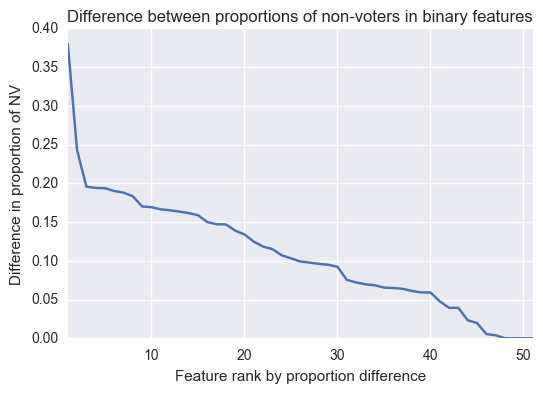

In [44]:
g = p_df.loc[:,'difference proportions'].plot(kind = 'line')
g.set(title = 'Difference between proportions of non-voters in binary features',
      ylabel = 'Difference in proportion of NV', xlabel = 'Feature rank by proportion difference')

The table and plot above reveals that with the exception of two features, the difference in proportion of non-voters for all other binary features is below 0.2. While even differences of below 0.2 can be statistically significant, as evidenced by p-values at or close to 0, it also indicates that there are no stand-out features that are strong predictors in of themselves.

Examining a binary feature by its difference in target feature proportions is fairly blunt. What if only a handful of respondents belong to one feature category, but all of them were non-voters? The resulting difference in proportions of non-voters for that feature would be unrealistically inflated. P-values are only moderately helpful in accounting for such situations, so we turn to a normalized [mutual information score](http://www.scholarpedia.org/article/Mutual_information#Interpretation) instead, where a value of 1 indicates a perfect correlation between two features and 0 indicates complete independence between two features.

In [89]:
# Exclude the first five values, as they constitute data leakage
p_df.sort_values(by = 'mutual_info', ascending = False).iloc[4:,:].head(10)

feature                                     description  \
49  VCF9030b                   Contacted by democratic party   
50  VCF9030c                   Contacted by republican party   
5    VCF0311             Care who wins presidential election   
38   VCF0729     Party with House majority prior to election   
39   VCF0731  Did R discuss politics with family and friends   
37   VCF0724      Did R watch TV programs about the election   
46   VCF9021              Did anyone talk to R about voting?   
47   VCF9029        Presidential race in R's state be close?   
21   VCF0392              Dislike anything: Republican party   
19   VCF0380              Dislike anything: Democratic party   

    difference_proportions  p-value  correlation  mutual_info  
49                0.147015  0.00000     0.145832     0.153686  
50                0.138981  0.00000     0.136119     0.152888  
5                 0.379882  0.00000     0.348378     0.107258  
38                0.150003  0.00000     0.170135     0.101682  
39                0.242803  0.00000     0.244435     0.098047  
37                0.190082  0.00000     0.171606     0.083556  
46                0.099163  0.00000     0.113476     0.068752  
47                0.005612  0.52517     0.006470     0.067917  
21                0.170130  0.00000     0.202415     0.055682  
19                0.166388  0.00000     0.199952     0.055488

Here we see that VCF0311, VCF0731, VCF0724, and VCF0392 reappear as important features as measured by mutual information with the target, so we may be reasonably confident that these will be among the more useful features for classification (provided they are not highly correlated with each other).

# A quick survey of continuous and quasi-continuous features
### Age and voting propensity
Conventional wisdom says that young voters are also low-propensity voters. Let's see if this is born out in the data.

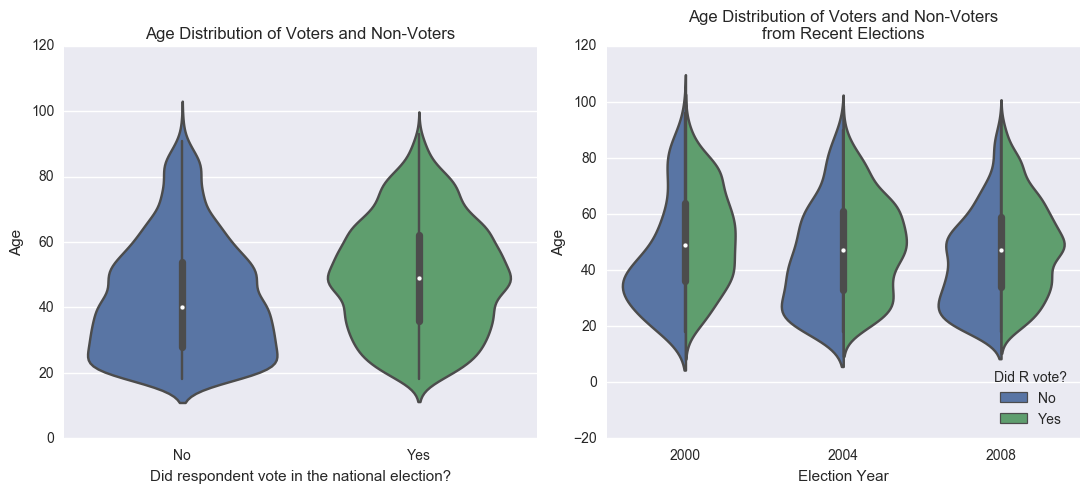

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5))
df_temp = df[df.age > 10]
g = sns.violinplot(x = df_temp.VCF0702, y = df_temp.age, bw = .2, ax = axes[0])
g.set(title = 'Age Distribution of Voters and Non-Voters', xticklabels = ['No','Yes'])
g.set(xlabel = 'Did respondent vote in the national election?', ylabel = 'Age')
g = sns.violinplot(x = df_temp.year, y = df_temp.age, hue = df_temp.VCF0702, ax = axes[1], split = True)
g.set(title = 'Age Distribution of Voters and Non-Voters\nfrom Recent Elections')
g.set(xlabel = 'Election Year', ylabel = 'Age')
handles, labels = g.get_legend_handles_labels()
g.legend(handles, ['No','Yes'], title = 'Did R vote?', loc = 4)
plt.tight_layout()

In fact, this very much appears to be the case, with the median voter being approximately 10 years older than the median non-voter. The characterization that non-voters skew much younger also appears to hold across different election years.

### Thermometer and index features
The vast majority of quasi-continuous data comes from a set of features associated with **"Thermometer"** type questions. In a thermometer question, the respondent is asked to rate an individual, group, or institution with a value, with lower values indicating a less favorable sentiment and higher values indicating a more favorable sentiment. Let's first examine how these thermometer features are correlated with each other.

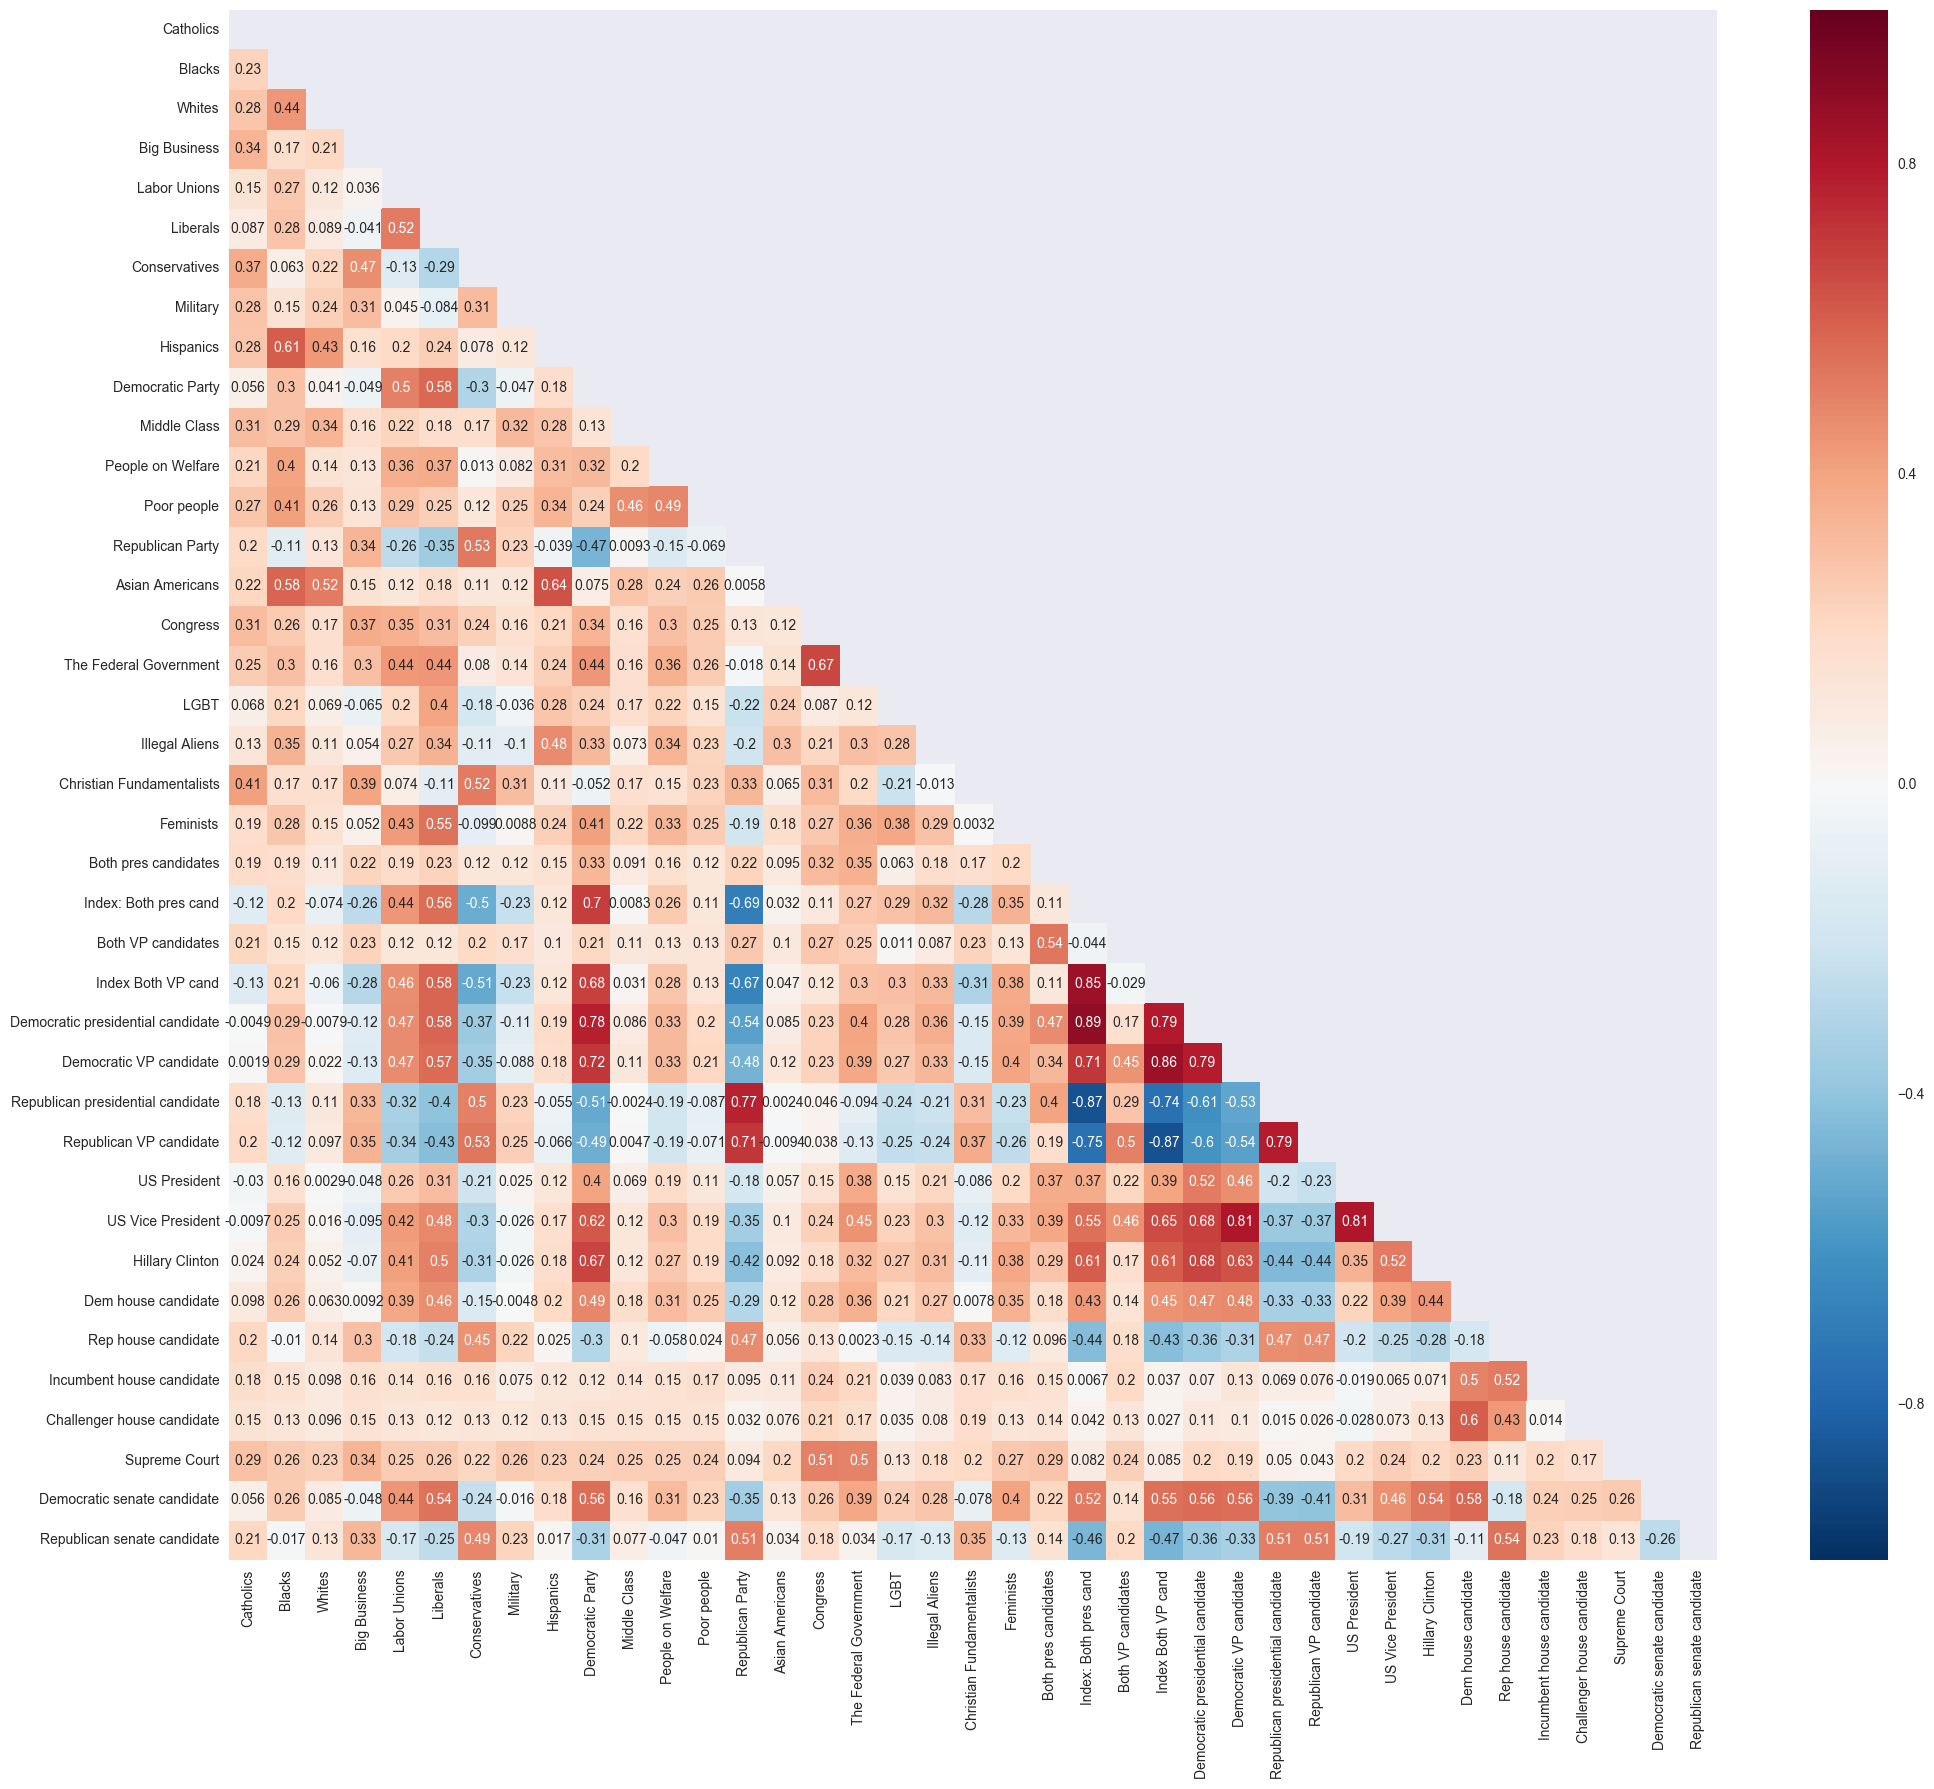

In [276]:
firstIndex = df.columns.get_loc('VCF0204')
lastIndex = df.columns.get_loc('VCF9057')

numerical_df = df.iloc[:,range(firstIndex,lastIndex+1,2)]
numerical_df = pd.concat([numerical_df, df.iloc[:,df.columns.get_loc('VCF0649'):df.columns.get_loc('VCF1016')]],
                         axis = 1)

numerical_df = numerical_df.drop(['VCF0801_dk'], axis = 1)
numerical_df = numerical_df.drop(['VCF0649','VCF0656','VCF0723','VCF0733','VCF0801'], axis = 1)
numerical_df = numerical_df.drop(['VCF1015','VCF0138','VCF0291'], axis = 1)

columns = []
for column in numerical_df.columns:
    new_name = feature_key[column]
    new_name = new_name.replace('Thermometer: ','')      
    columns.append(new_name)
numerical_df.columns = columns
                        
fig, axes = plt.subplots(1,1,figsize = (24,20))
corr = numerical_df.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, ax = axes, mask = mask, annot = True)

With a few exceptions, the thermometer features do not appear to be significantly correlated with each other. This is encouraging, as [multicollinearity](https://onlinecourses.science.psu.edu/stat501/node/344) can cause a whole host of [problems](https://onlinecourses.science.psu.edu/stat501/node/346) when trying to extract insight from a linear model like logistic regression. If it does so happen that a linear model is needed, then it will be necessary to break the correlation chains present in these thermometer features.

How exactly are these thermometer features distrbuted?

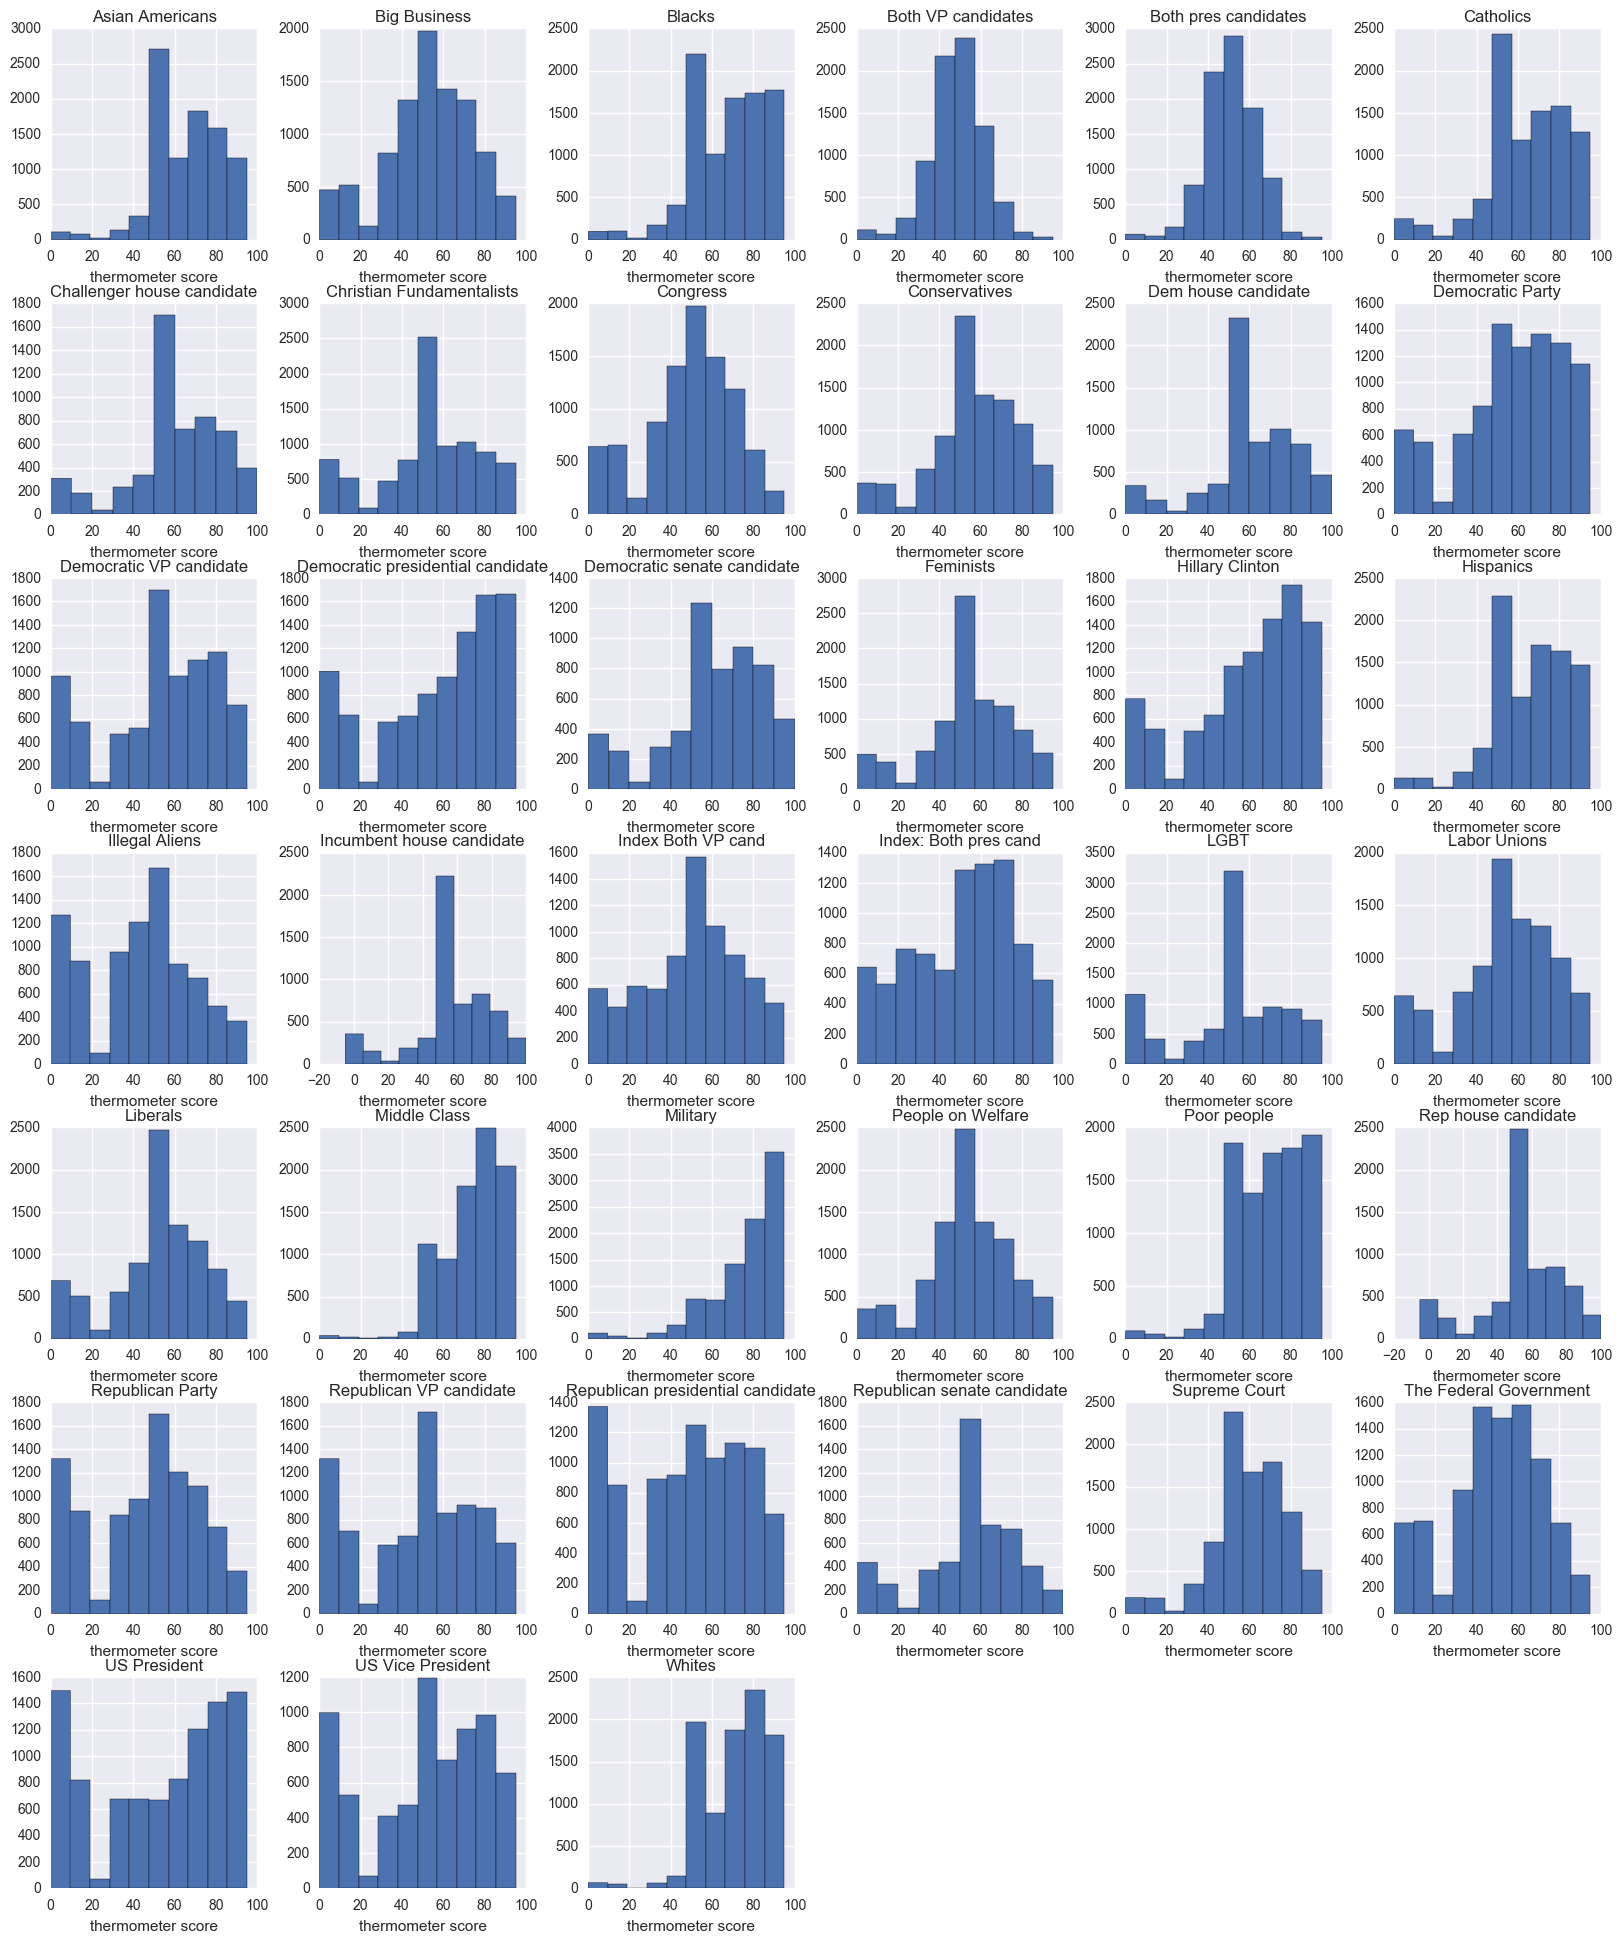

In [277]:
axes = numerical_df.iloc[:,:].hist(figsize = (20,24))
for row in axes:
    for ax in row:
        ax.set_xlabel('thermometer score')

While the thermometer scores for these features can be distributed in any number of ways, it is often the case that a score of 50, indicating a neutral sentiment, is the most prevalent. Let's see what proportion of non-voters comprise each thermometer score bucket.

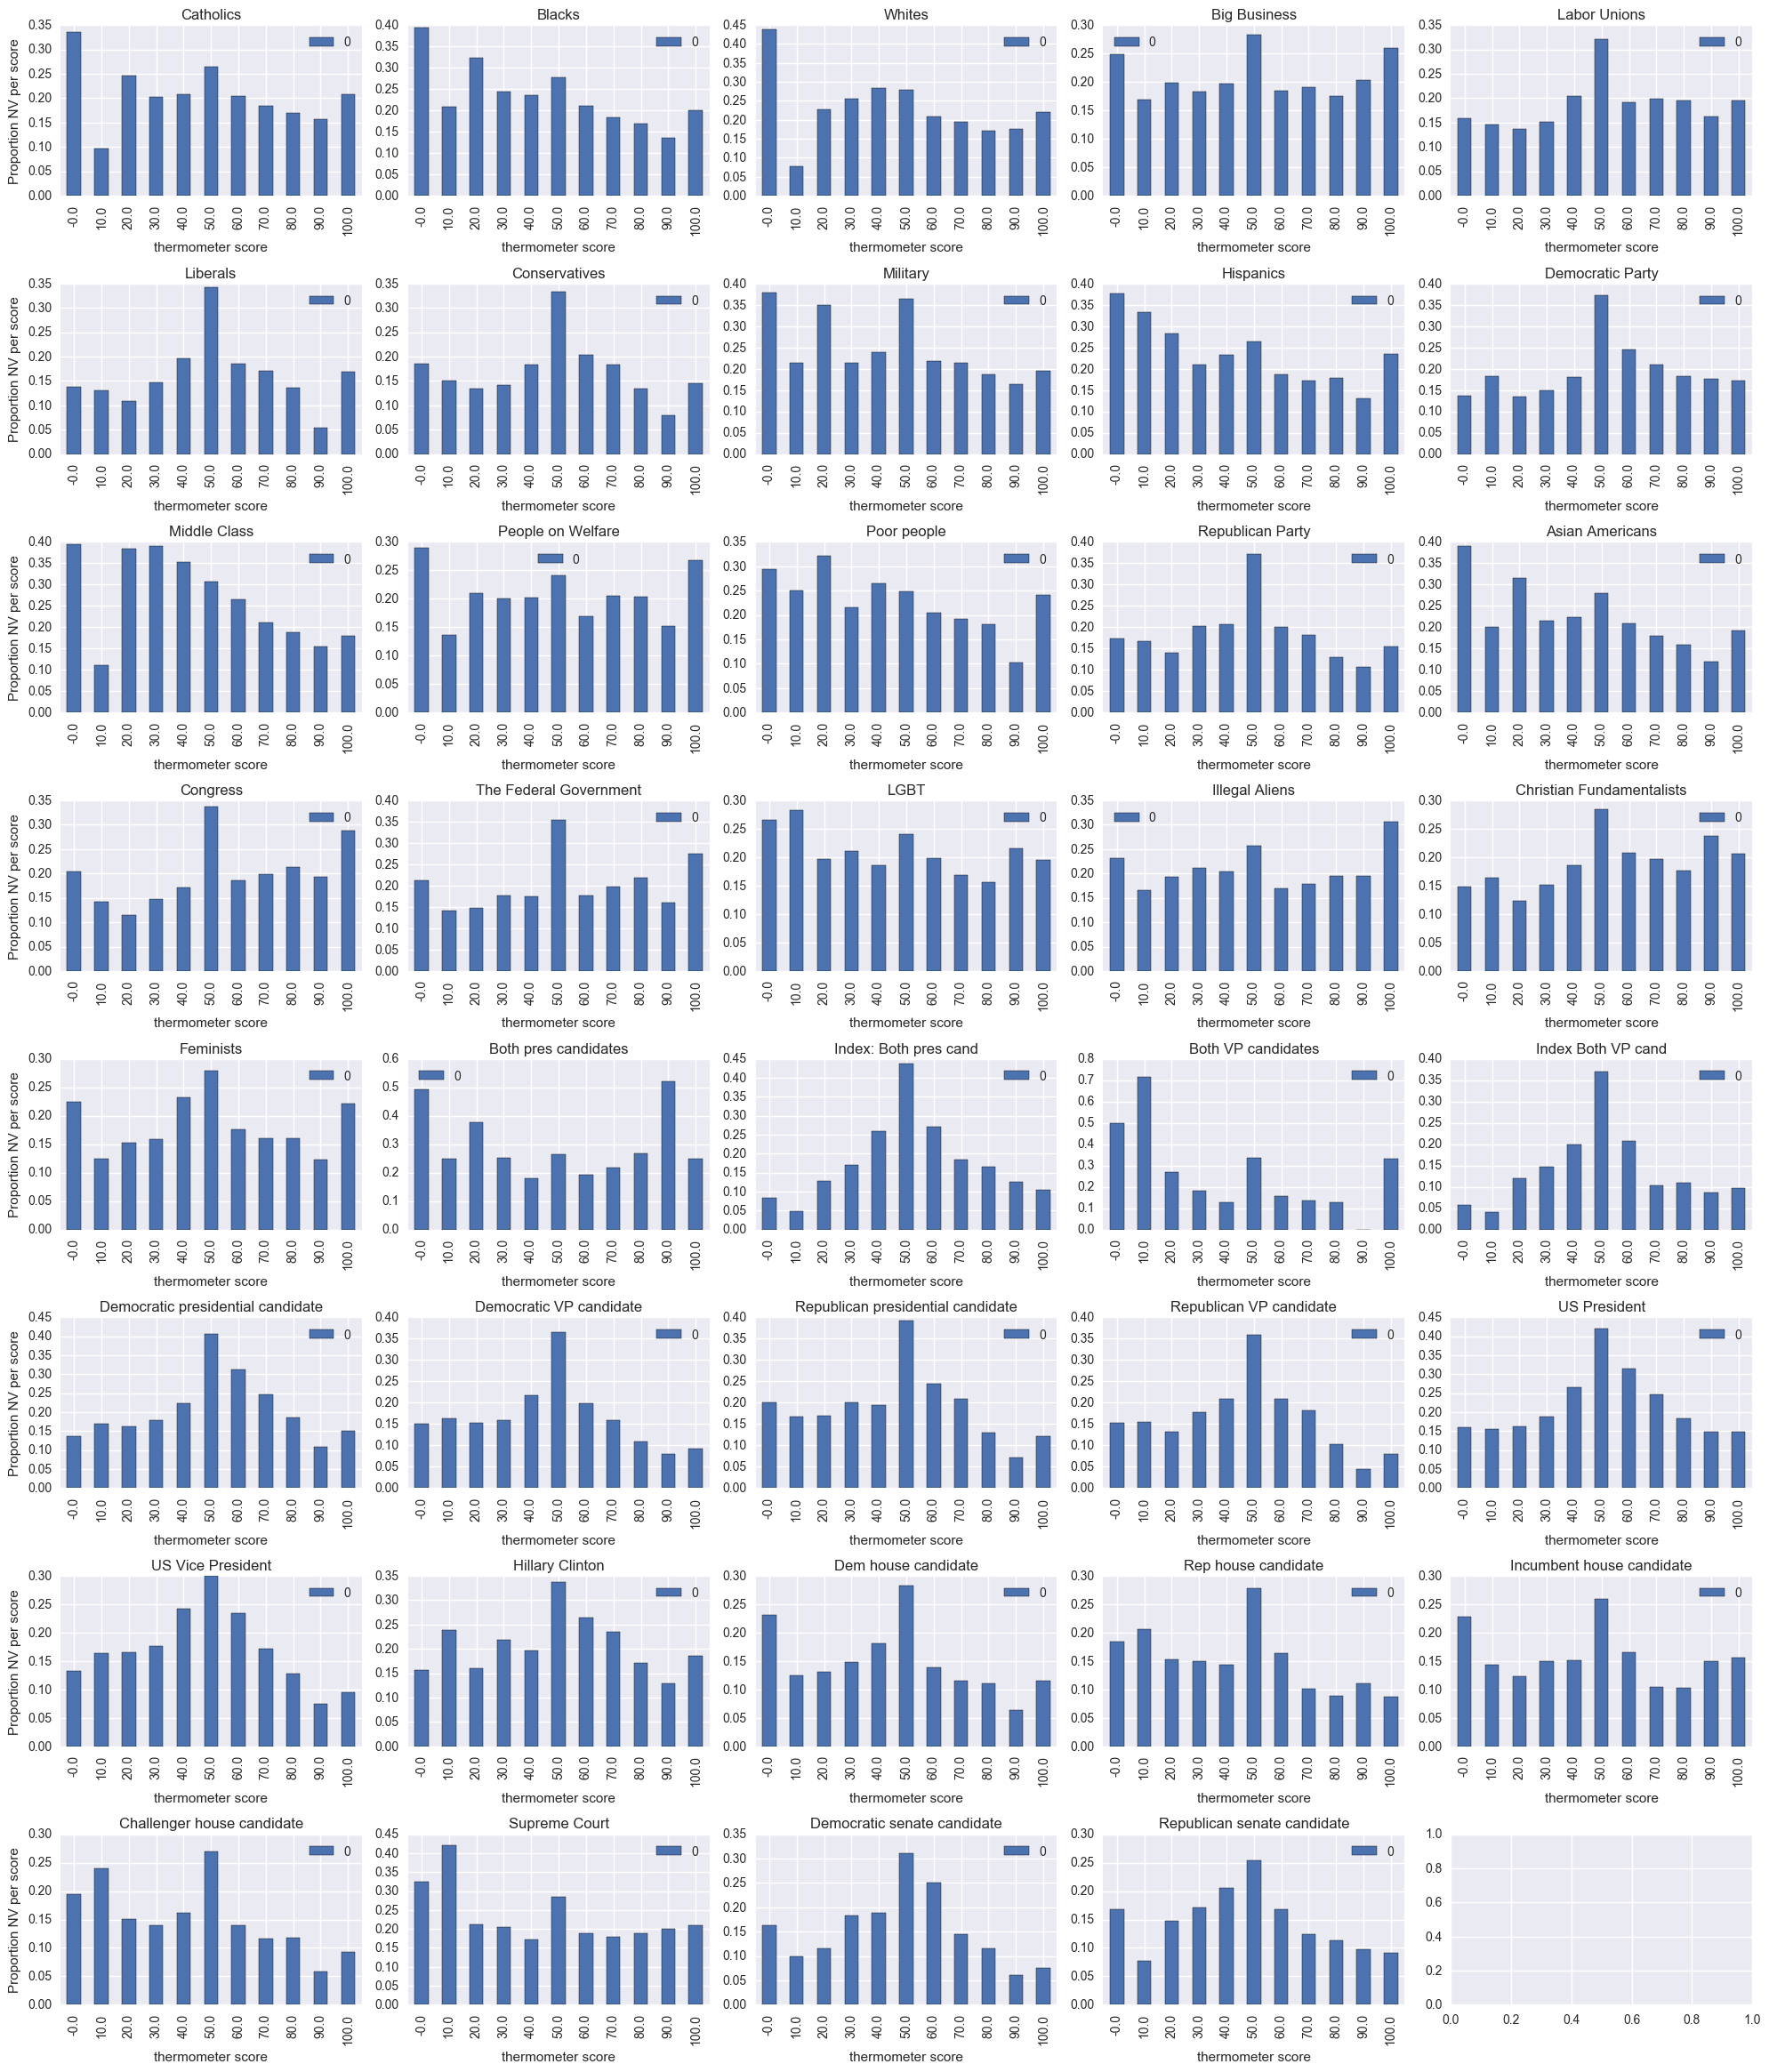

In [278]:
n = numerical_df.shape[1]
fig, axes = plt.subplots(n // 5 + 1, 5, figsize = (20, 0.6 * n))

for index in range(0, numerical_df.shape[1]):
    feature = numerical_df.iloc[:,index]
    feature = round(feature.fillna(feature.median()), -1) // 2 * 2
    feature = pd.concat([feature, np.logical_not(df.VCF0702)], axis = 1)
    feature = feature.groupby([numerical_df.columns[index],'VCF0702']).size().unstack('VCF0702').fillna(0)
    feature = feature[1] / (feature[0] + feature[1])
    g = pd.DataFrame(feature).plot(kind = 'bar', ax = axes[index // 5][index % 5])
    g.set(title = numerical_df.columns[index], xlabel = 'thermometer score')
    
    if index % 5 == 0:
        g.set_ylabel('Proportion NV per score')
    
plt.tight_layout()

It appears that with partisan subjects, such as prominent political figures, ideologies, and parties, a more neutral score indicates a greater likelihood of not voting.

Let's transform all thermometer features into sentiment intensity features by measuring the distance of a thermometer score from 50, dividing by 10, and rounding to the nearest number, resulting in values ranging from **0 to 5**.

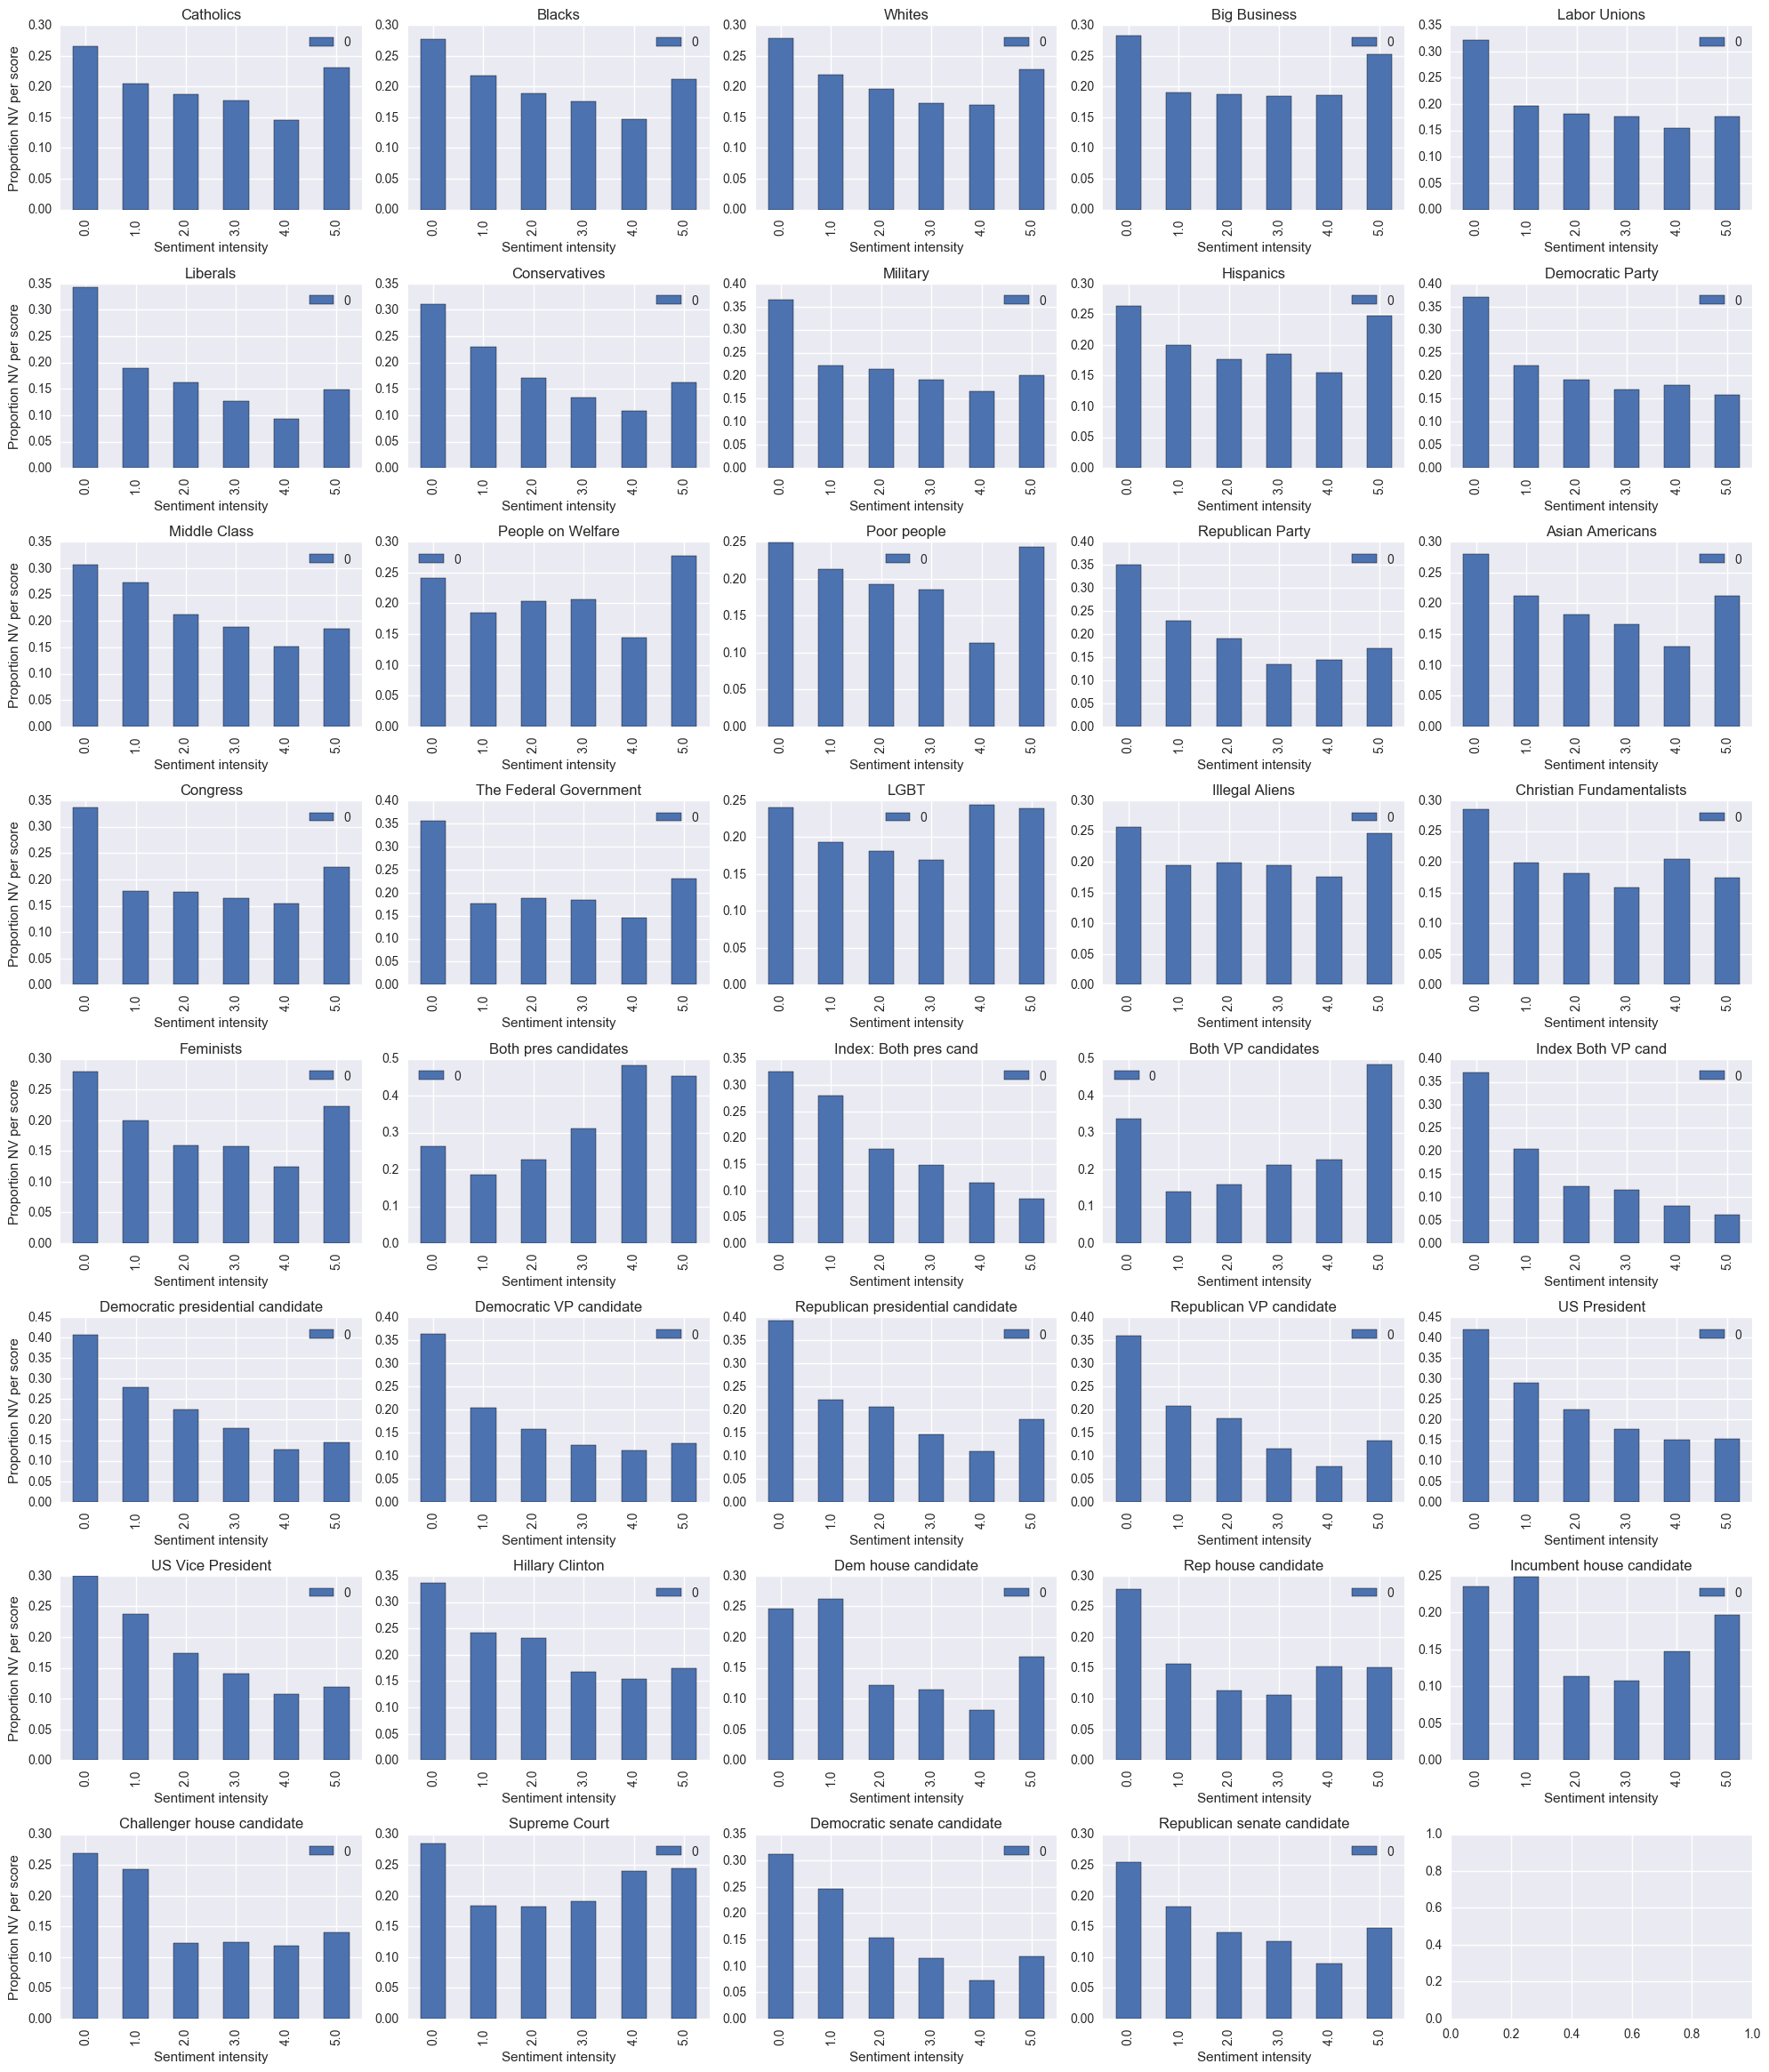

In [279]:
n = numerical_df.shape[1]
fig, axes = plt.subplots(n // 5 + 1, 5, figsize = (20, 0.6 * n))

for index in range(0, numerical_df.shape[1]):
    feature = numerical_df.iloc[:,index]
    feature = round(feature.fillna(feature.mean()),-1) // 10
    feature = abs(feature - 5)
    feature = pd.concat([feature, np.logical_not(df.VCF0702)], axis = 1)
    feature_name = feature.columns[0]
    
    nv = feature.groupby(feature_name).agg(sum)
    total = feature.groupby(feature_name).size()

    nv_prop = pd.DataFrame(nv.VCF0702 / total)
    g = nv_prop.plot(kind = 'bar', ax = axes[index // 5][index % 5])
    g.set_xlabel('Sentiment intensity')
    g.set_title(feature_name)
    
    if index % 5 == 0:
        g.set_ylabel('Proportion NV per score')
    
plt.tight_layout()

For many thermometer features, it appears to be true that lower sentiment intensity correlates to a greater likelihood of not voting. Whether the trend in some of these features is strong enough to be useful in a classification problem remains an open question, but it may be worthwhile to use the thermometer features to derive a set of intensity features nonetheless in case we decide to use a linear model.

# A quick survey of ordinal features (and binary features derived from them)
Our approach towards exploring ordinal features is much the same as for quasi-continuous features. Some features correspond to questions asking the respondent for their opinion on a subject, with valid responses ranging between "strongly disagree" to "strongly agree." Other features correspond to questions assessing the respondent's political knowledge.

Features with a "_dk" postfix record whether the respondent answered "don't know" to a particular question.

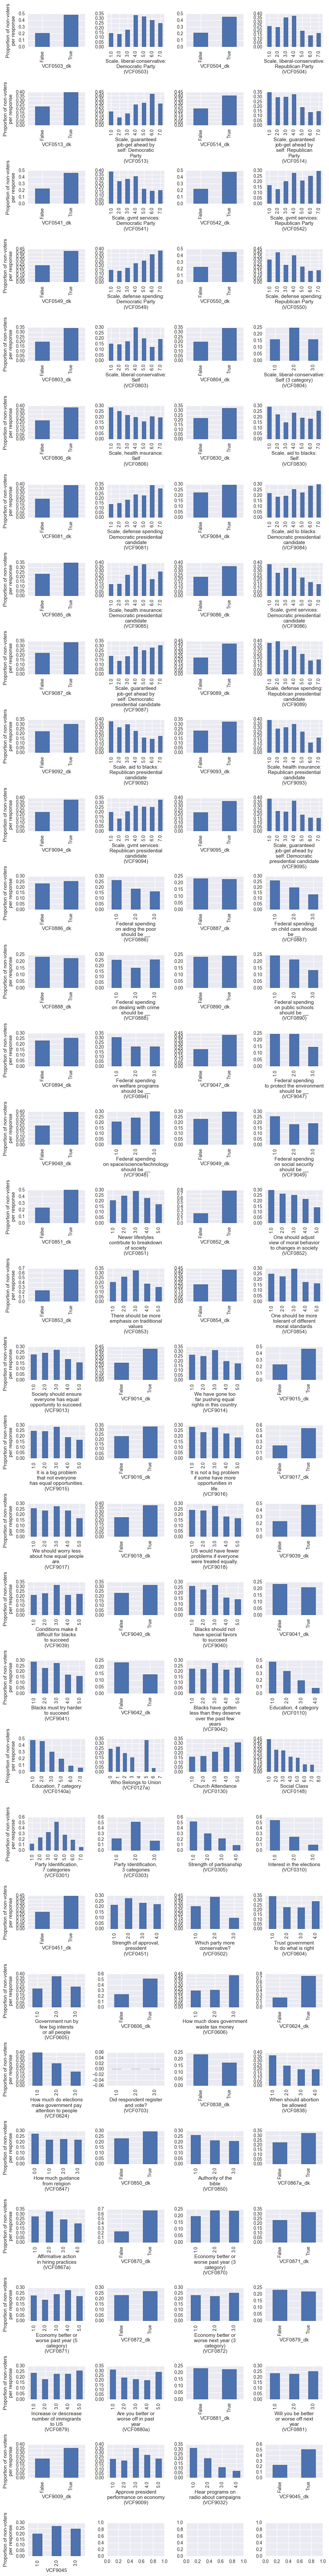

In [196]:
temp_df = df[:]

firstIndex = temp_df.columns.get_loc('VCF0503_dk')
lastIndex = temp_df.columns.get_loc('VCF9045')
num_plots = lastIndex - firstIndex + 1
fig, axes = plt.subplots(num_plots // 4 + 1, 4, figsize = (10, 0.6 * num_plots))

for axesIndex, index in zip(range(0, num_plots), range(firstIndex, lastIndex + 1)):
    
    r = temp_df.groupby([temp_df.columns[index],'VCF0702']).size()
    r = r.unstack('VCF0702')
    r['non_voter_proportion'] = r.iloc[:,0] / (r.iloc[:,1] + r.iloc[:,0])
    g = r.non_voter_proportion.plot(kind = 'bar', ax = axes[axesIndex // 4][axesIndex % 4])
    if axesIndex % 4 == 0:
        g.set_ylabel('Proportion of non-voters\nper response')
    if temp_df.columns[index] in feature_key:
        title = wrap_text(feature_key[temp_df.columns[index]]) + '\n({})'.format(temp_df.columns[index])
        g.set_xlabel(title)
    
plt.tight_layout()
fig.set_label('Test')

A cursory review of the plots above show three things: 
1.  Certain features are reasonably correlated with likelihood to not vote, like VCF0932, VCF0310, VCF0148, and VCF0140a among others. However, as with binary features, the predictive power of ordinal features also depends on how respondents are distributed within each feature category. So while some features show promise, their usefulness for classification remain unknown for now.

2. As with the thermometer features, some ordinal features may also benefit from a transformation that measures the distance from the center of the distribution, like VCF9009 and VCF0851, for example.

3. In general, a respondent that answers 'don't know' to a question is more likely, sometimes significantly so, to be a non-voter.

Given the third observation, it might be reasonable to expect that the more a respondent answers "don't know", the more likely he/she is to be a non-voter. We can check if the data supports this notion with the following plots.

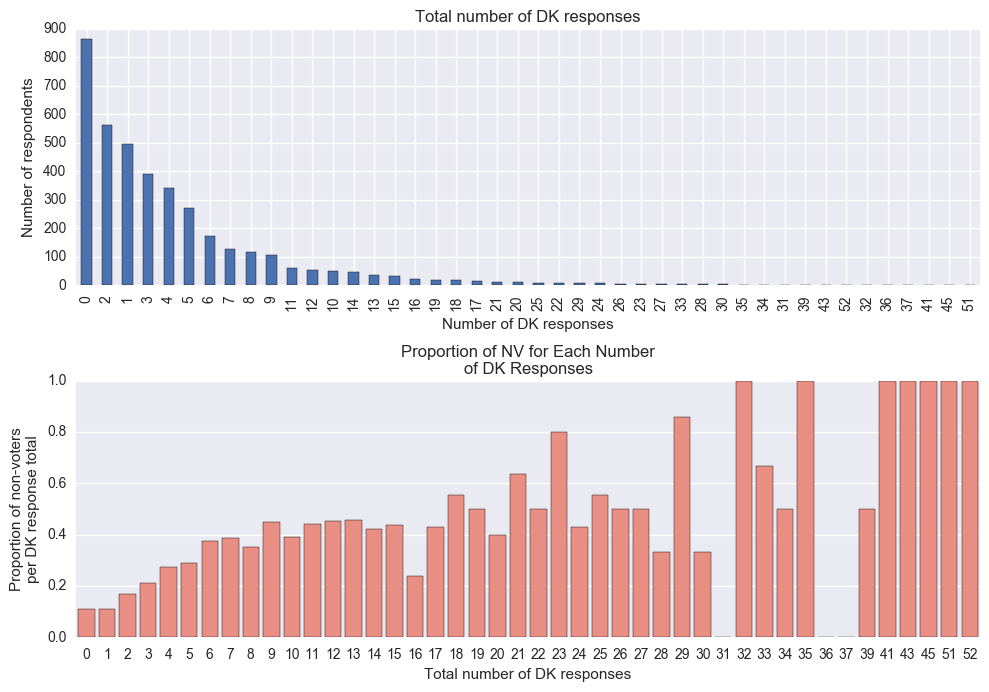

In [197]:
fig, axes = plt.subplots(2,1,figsize = (10,7))

dksum_df = df.loc[:,df.columns.str.contains('dk')].astype(int)
dksum_df['total'] = dksum_df.iloc[:,1:].sum(axis = 1)
g = dksum_df.total.value_counts().plot(kind = 'bar', ax = axes[0])
g.set_title('Total number of DK responses')
g.set_xlabel('Number of DK responses')
g.set_ylabel('Number of respondents')

dksum_df = pd.concat([dksum_df, df.VCF0702], axis = 1)
dksum_df = dksum_df.groupby(['total','VCF0702']).size()
dksum_df = dksum_df.unstack('VCF0702')
dksum_df = dksum_df.fillna(0)
dksum_df['nonvote_proportion'] = dksum_df.iloc[:,0] / (dksum_df.iloc[:,0] + dksum_df.iloc[:,1])

g = sns.barplot(x = dksum_df.index, y = dksum_df.nonvote_proportion, color = 'salmon', ax = axes[1])
g.set(title = 'Proportion of NV for Each Number\nof DK Responses', xlabel = 'Total number of DK responses',
     ylabel = 'Proportion of non-voters\nper DK response total')
plt.tight_layout()

It appears that a respondent's likelihood to stay at home on election day increases with each "don't know" response up to 9 such responses. Beyond that the data becomes too sparse to make meaningful conclusions.